In [227]:
import numpy as np
import tensorflow as tf
import PIL.Image

In [228]:
def RGB_to_Y(x):
    x = tf.convert_to_tensor(x)
    x = tf.reshape(x,(3,32,32))
    x = tf.transpose(x,(1,2,0))
    x = tf.image.rgb_to_grayscale(x)
    return x
def display_Y(Y):
    return PIL.Image.fromarray(np.array(Y),'L')

In [320]:
X = tf.map_fn(RGB_to_Y,val["data"][0:5000])
y = tf.convert_to_tensor(val["labels"][0:5000])

X_val = tf.map_fn(RGB_to_Y,val["data"][-100:])
y_val = tf.convert_to_tensor(val["labels"][-100:])

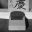

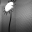

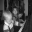

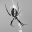

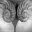

In [321]:
for i_img in range(5):
    img = display_Y(X[i_img,:,:,0])
    display(img)

In [338]:
# From Apache Licensed tensorflow compression example
# https://github.com/tensorflow/docs/blob/master/site/en/tutorials/generative/data_compression.ipynb

import tensorflow as tf
import tensorflow_compression as tfc
import tensorflow_datasets as tfds

def make_analysis_transform(latent_dims):
  """Creates the analysis (encoder) transform."""
  return tf.keras.Sequential([
      tf.keras.layers.Conv2D(
          20, 5, use_bias=True, strides=2, padding="same",
          activation="leaky_relu", name="conv_1"),
      tf.keras.layers.Conv2D(
          50, 5, use_bias=True, strides=2, padding="same",
          activation="leaky_relu", name="conv_2"),
      tf.keras.layers.Flatten(),
      tf.keras.layers.Dense(
          500, use_bias=True, activation="leaky_relu", name="fc_1"),
      tf.keras.layers.Dense(
          latent_dims, use_bias=True, activation=None, name="fc_2"),
  ], name="analysis_transform")

def make_synthesis_transform():
  """Creates the synthesis (decoder) transform."""
  return tf.keras.Sequential([
      tf.keras.layers.Dense(
          500, use_bias=True, activation="leaky_relu", name="fc_1"),
      tf.keras.layers.Dense(
          3200, use_bias=True, activation="leaky_relu", name="fc_2"),
      tf.keras.layers.Reshape((8, 8, 50)),
      tf.keras.layers.Conv2DTranspose(
          20, 5, use_bias=True, strides=2, padding="same",
          activation="leaky_relu", name="conv_1"),
      tf.keras.layers.Conv2DTranspose(
          1, 5, use_bias=True, strides=2, padding="same",
          activation="leaky_relu", name="conv_2"),
  ], name="synthesis_transform")

class Imgnet32yCompressionTrainer(tf.keras.Model):
  """Model that trains a compressor/decompressor for MNIST."""

  def __init__(self, latent_dims):
    super().__init__()
    self.analysis_transform = make_analysis_transform(latent_dims)
    self.synthesis_transform = make_synthesis_transform()
    self.prior_log_scales = tf.Variable(tf.zeros((latent_dims,)))

  @property
  def prior(self):
    return tfc.NoisyLogistic(loc=0., scale=tf.exp(self.prior_log_scales))

  def call(self, x, training):
    """Computes rate and distortion losses."""
    # Ensure inputs are floats in the range (0, 1).
    x = tf.cast(x, self.compute_dtype) / 255.
    x = tf.reshape(x, (-1, 32, 32, 1))

    # Compute latent space representation y, perturb it and model its entropy,
    # then compute the reconstructed pixel-level representation x_hat.
    y = self.analysis_transform(x)
    entropy_model = tfc.ContinuousBatchedEntropyModel(
        self.prior, coding_rank=1, compression=False)
    y_tilde, rate = entropy_model(y, training=training)
    x_tilde = self.synthesis_transform(y_tilde)

    # Average number of bits per MNIST digit.
    rate = tf.reduce_mean(rate)

    # Mean absolute difference across pixels.
    distortion = tf.reduce_mean(abs(x - x_tilde))

    return dict(rate=rate, distortion=distortion)

def pass_through_loss(_, x):
  # Since rate and distortion are unsupervised, the loss doesn't need a target.
  return x

def make_imgnet32y_compression_trainer(lmbda, latent_dims=50):
  trainer =  Imgnet32yCompressionTrainer(latent_dims)
  trainer.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
    # Just pass through rate and distortion as losses/metrics.
    loss=dict(rate=pass_through_loss, distortion=pass_through_loss),
    metrics=dict(rate=pass_through_loss, distortion=pass_through_loss),
    loss_weights=dict(rate=1., distortion=lmbda),
  )
  return trainer

def add_rd_targets(image, label):
  # Training is unsupervised, so labels aren't necessary here. However, we
  # need to add "dummy" targets for rate and distortion.
  return image, dict(rate=0., distortion=0.)

def train_imgnet32y_model(lmbda):
  trainer = make_imgnet32y_compression_trainer(lmbda)
  trainer.fit(
      training_dataset.map(add_rd_targets).batch(128).prefetch(8),
      epochs=15,
      validation_data=validation_dataset.map(add_rd_targets).batch(128).cache(),
      validation_freq=1,
      verbose=1,
  )
  return trainer

class Imgnet32yCompressor(tf.keras.Model):
  """Compresses MNIST images to strings."""

  def __init__(self, analysis_transform, entropy_model):
    super().__init__()
    self.analysis_transform = analysis_transform
    self.entropy_model = entropy_model

  def call(self, x):
    # Ensure inputs are floats in the range (0, 1).
    x = tf.cast(x, self.compute_dtype) / 255.
    y = self.analysis_transform(x)
    # Also return the exact information content of each digit.
    _, bits = self.entropy_model(y, training=False)
    return self.entropy_model.compress(y), bits

class Imgnet32yDecompressor(tf.keras.Model):
  """Decompresses MNIST images from strings."""

  def __init__(self, entropy_model, synthesis_transform):
    super().__init__()
    self.entropy_model = entropy_model
    self.synthesis_transform = synthesis_transform

  def call(self, string):
    y_hat = self.entropy_model.decompress(string, ())
    x_hat = self.synthesis_transform(y_hat)
    # Scale and cast back to 8-bit integer.
    return tf.saturate_cast(tf.round(x_hat * 255.), tf.uint8)

def make_imgnet32y_codec(trainer, **kwargs):
  # The entropy model must be created with `compression=True` and the same
  # instance must be shared between compressor and decompressor.
  entropy_model = tfc.ContinuousBatchedEntropyModel(
      trainer.prior, coding_rank=1, compression=True, **kwargs)
  compressor = Imgnet32yCompressor(trainer.analysis_transform, entropy_model)
  decompressor = Imgnet32yDecompressor(entropy_model, trainer.synthesis_transform)
  return compressor, decompressor

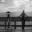

In [340]:
strings, entropies = compressor(X_val[0:5])
reconstructions = decompressor(strings)
display_Y(X_val[0][:,:,0])

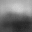

In [341]:
display_Y(reconstructions[0][:,:,0])

In [339]:
training_dataset = tf.data.Dataset.from_tensor_slices((X,y))
validation_dataset = tf.data.Dataset.from_tensor_slices((X_val,y_val))
trainer = train_imgnet32y_model(lmbda=500)
compressor, decompressor = make_imgnet32y_codec(trainer)

Epoch 1/30


2023-04-17 21:18:59.131252: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype int64 and shape [5000]
	 [[{{node Placeholder/_1}}]]


39/40 [============================>.] - ETA: 0s - loss: 218.4374 - distortion_loss: 0.2255 - rate_loss: 105.6871 - distortion_pass_through_loss: 0.2255 - rate_pass_through_loss: 105.6871

2023-04-17 21:19:02.433711: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype int64 and shape [100]
	 [[{{node Placeholder/_1}}]]


40/40 [==============================] - 4s 17ms/step - loss: 218.3911 - distortion_loss: 0.2254 - rate_loss: 105.6813 - distortion_pass_through_loss: 0.2242 - rate_pass_through_loss: 105.5957 - val_loss: 204.7802 - val_distortion_loss: 0.2095 - val_rate_loss: 100.0471 - val_distortion_pass_through_loss: 0.2095 - val_rate_pass_through_loss: 100.0471
Epoch 2/30
40/40 [==============================] - 0s 10ms/step - loss: 175.1676 - distortion_loss: 0.1476 - rate_loss: 101.3876 - distortion_pass_through_loss: 0.1472 - rate_pass_through_loss: 101.3680 - val_loss: 173.1328 - val_distortion_loss: 0.1473 - val_rate_loss: 99.4652 - val_distortion_pass_through_loss: 0.1473 - val_rate_pass_through_loss: 99.4652
Epoch 3/30
40/40 [==============================] - 0s 9ms/step - loss: 165.0468 - distortion_loss: 0.1308 - rate_loss: 99.6334 - distortion_pass_through_loss: 0.1305 - rate_pass_through_loss: 99.6134 - val_loss: 168.5641 - val_distortion_loss: 0.1430 - val_rate_loss: 97.0679 - val_dist